In [2]:
# import typing
# import io
import os

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

# from urllib.request import urlretrieve

from PIL import Image
import cv2
import torchvision

from transformers import ViTModel
from transformers import ViTFeatureExtractor, AutoImageProcessor
import sys
import torchvision.transforms as transforms

# from models.modeling import VisionTransformer, CONFIGS

2024-10-10 12:47:48.235690: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-10 12:47:49.181628: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(250, 250, 3)


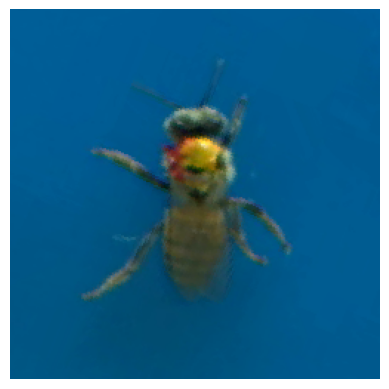

In [9]:
test_image_path = "/home/lmeyers/summer_bee_data_reextract/images/young-adults-white-blue-outside-97-128_batch_2_pass_2.mp4.track000247.frame044738.png" # "/home/lmeyers/SLEAP_files/Bee_imgs/old/filesort/unhelpful/no_paint/f2x2022_06_20.mp4.track000003.frame001871.jpg" #"/home/lmeyers/DSC_4539.png" # "/home/lmeyers/SinlgeBeeTest.png"  #Panamenis-cropped.png" #
test_image = cv2.imread(test_image_path)
test_image = cv2.cvtColor(test_image, cv2.COLOR_RGB2BGR)
test_image_np = np.array(test_image)
print(test_image.shape)
plt.imshow(test_image)
plt.axis("off")
plt.show()

In [4]:
  
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"using device: {device}")


using device: cuda


In [5]:
# Test Image
sys.path.insert(0,"../")

# print('Getting ViT feature extractor...')
model_name = 'google/vit-base-patch16-224-in21k'
#model_path = "/home/lmeyers/contrastive_learning_new_training/64_ids_batch1_sample_num_64/64_ids_batch1_sample_num_64.pth"

feature_extractor = AutoImageProcessor.from_pretrained(model_name)


# model = torch.load(model_path)
# model = model.vit

model = ViTModel.from_pretrained(model_name)
model.config.output_attentions = True
model.to(device)
print(model.config.output_attentions)


True


In [1]:
import open_clip

bio_model, preprocess_train, preprocess_val = open_clip.create_model_and_transforms('hf-hub:imageomics/bioclip',jit=False)
print(bio_model.visual.c)
tokenizer = open_clip.get_tokenizer('hf-hub:imageomics/bioclip')
# bio_model.to(device)
print(bio_model)


# torch.save(bio_model,"bioClip_output_att.pth")

/home/lmeyers/anaconda3/envs/mlenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
    (patch_dropout): Identity()
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-11): 12 x ResidualAttentionBlock(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): GELU(approximate='none')
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ls_2): Identity()
        )
      )
    )
    (ln_post): LayerNorm((768,), eps=1e-05, elementwise_affine

In [11]:
import torch.onnx

torch.onnx.export(bio_model,x_ct,"/home/lmeyers/bio_clip_att_out.onnx")

============= Diagnostic Run torch.onnx.export version 2.0.0+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 1 ERROR ========================
ERROR: missing-standard-symbolic-function
Exporting the operator 'aten::unflatten' to ONNX opset version 14 is not supported. Please feel free to request support or submit a pull request on PyTorch GitHub: https://github.com/pytorch/pytorch/issues.
None
<Set verbose=True to see more details>




UnsupportedOperatorError: Exporting the operator 'aten::unflatten' to ONNX opset version 14 is not supported. Please feel free to request support or submit a pull request on PyTorch GitHub: https://github.com/pytorch/pytorch/issues.

In [10]:

from transformers import CLIPFeatureExtractor
clip_flattener = CLIPFeatureExtractor()
test_image = transforms.functional.to_pil_image(test_image) 
x_c = clip_flattener(test_image)['pixel_values']
x_ct = torch.tensor(x_c, dtype=torch.float)



torch.FloatTensor


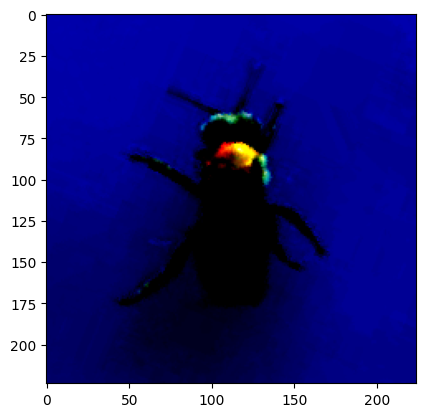

In [6]:
#print(test_image_tens.size())
#x = test_image_tens
#print(x.size())
x = x_ct

print(x.type())
x_m = x.squeeze(0)
x_mcl = torch.moveaxis(x_m,0,-1)

x_np = x_mcl.detach().cpu().numpy()

plt.imshow(x_np)
plt.show()


In [41]:
x_ca = np.moveaxis(x_c[0],0,-1)
first_patch = x_ca[0:16,0:16,:]
print(first_patch.shape)
flat_patch = first_patch.flatten()
print(flat_patch.shape)
display_ind_barcode(flat_patch,cmap="jet")
from torch import conv1d
flat_conv = conv1d(torch.tensor(flat_patch))
print(flat_conv.size())

(16, 16, 3)
(768,)


TypeError: conv1d() received an invalid combination of arguments - got (Tensor), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)


In [9]:
bio_output = bio_model(x)
vis_out = bio_output[0]

logits = vis_out[0]
print(logits.size())
att_mat = vis_out[1]
att_mat = torch.stack(att_mat)
att_mat = torch.moveaxis(att_mat,1,-1)
print(att_mat.size())
att_mat = torch.squeeze(att_mat)
print(att_mat.size())
# output_pred = torch.nn.Softmax(output)
# print(output_pred)
# print(torch.argmax(output[0]))



torch.Size([1, 512])
torch.Size([12, 197, 197, 1])
torch.Size([12, 197, 197])


In [42]:
print(bio_model.visual.conv1)
conv_out = torch.moveaxis(bio_model.visual.conv1(x_ct.to(device)).squeeze(0),0,-1)
print(conv_out.size())
from vis_utils import display_ind_barcode
display_ind_barcode(conv_out[0][0].detach().cpu().numpy(),cmap="jet")

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
torch.Size([14, 14, 768])


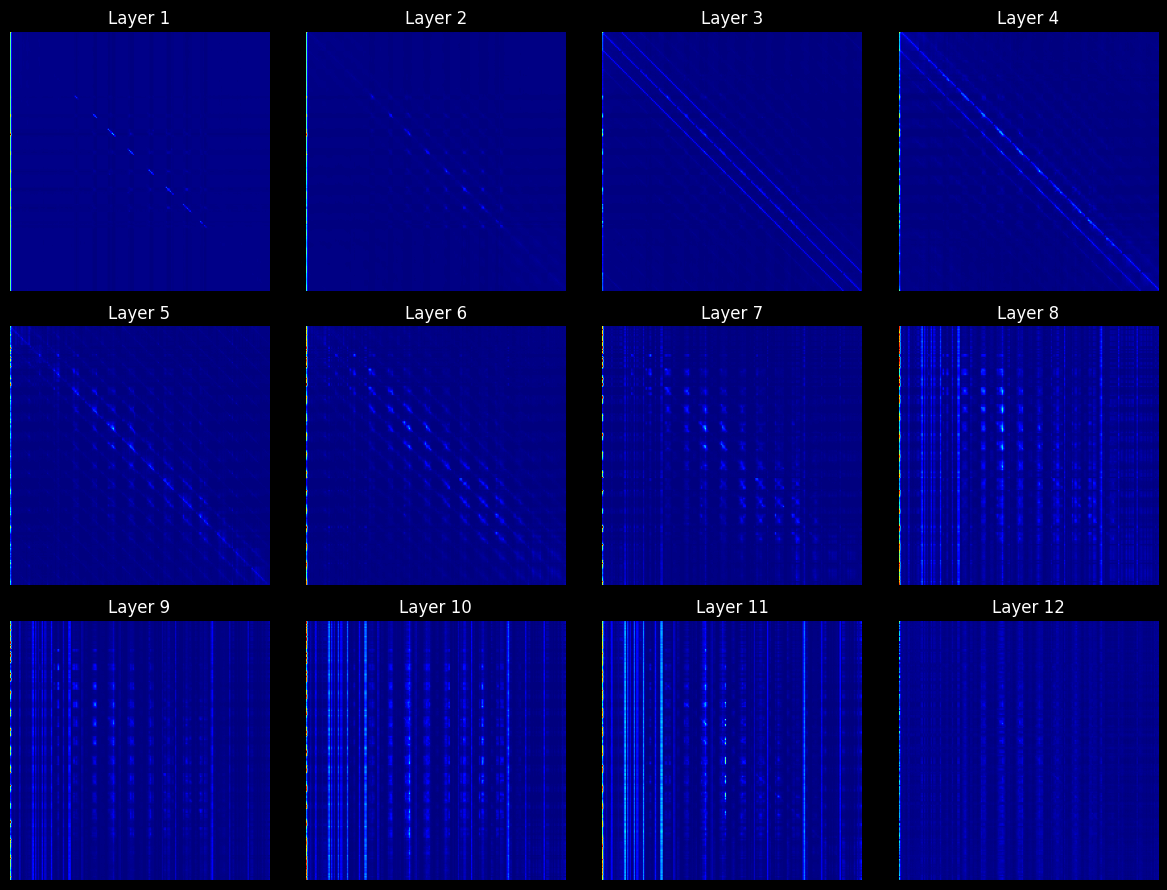

torch.Size([197, 197])


(-0.5, 196.5, 196.5, -0.5)

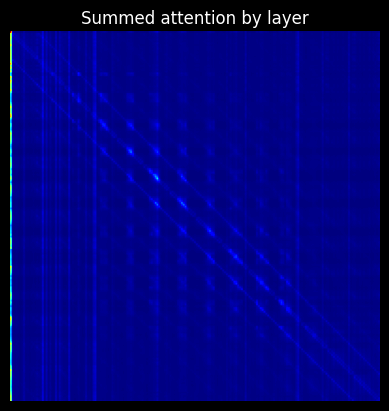

In [43]:

num_layers = len(att_mat)

# Set up a figure with appropriate grid size (3x4 for 12 subplots)
fig, axes = plt.subplots(3, 4, figsize=(12, 9))


# Iterate over layers and their corresponding subplot axes
for i, layer in enumerate(att_mat):
    ax = axes[i // 4, i % 4]  # Get the correct subplot (3 rows, 4 columns)
    ax.imshow(layer.detach().cpu().numpy(), cmap='jet')  # Display layer
    ax.set_title(f'Layer {i+1}')  # Add layer label
    ax.axis('off')  # Hide axes

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the figure with all subplots
plt.show()

plt.style.use('dark_background')
att_mat_flat = att_mat.sum(axis=0)
print(att_mat_flat.size())
plt.title("Summed attention by layer")
plt.imshow(att_mat_flat.detach().cpu().numpy(), cmap='jet')
plt.axis("off")


In [174]:
#VIT CODE 
output = model(x)
logits = output["pooler_output"]
att_mat = output["attentions"]
att_mat = torch.stack(att_mat).squeeze(1)
print(att_mat.size())
att_mat = torch.mean(att_mat, dim=1) #dont need mean for bioclip

torch.Size([12, 12, 197, 197])


In [44]:

im = test_image
# Average the attention weights across all heads.

print(att_mat.size())

# To account for residual connections, we add an identity matrix to the
# attention matrix and re-normalize the weights.
residual_att = torch.eye(att_mat.size(1)).to(device)

aug_att_mat = att_mat + residual_att
aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)
print(aug_att_mat.size())

# Recursively multiply the weight matrices
joint_attentions = torch.zeros(aug_att_mat.size()).to(device)
joint_attentions[0] = aug_att_mat[0]
print(aug_att_mat.size(),aug_att_mat[0].size())
print(joint_attentions.size())

for n in range(1, aug_att_mat.size(0)):
    joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])
    print(f"multiplying aug_att_mat[{n}] by joint[{n-1}] to set joint[{n}]")
# Attention from the output token to the input space.
v = joint_attentions[-1]
grid_size = int(np.sqrt(aug_att_mat.size(-1)))
mask = v[0, 1:].reshape(grid_size, grid_size).cpu().detach().numpy()
mask = cv2.resize(mask / mask.max(), (test_image_np.shape[1], test_image_np.shape[0]))[..., np.newaxis]


torch.Size([12, 197, 197])
torch.Size([12, 197, 197])
torch.Size([12, 197, 197]) torch.Size([197, 197])
torch.Size([12, 197, 197])
multiplying aug_att_mat[1] by joint[0] to set joint[1]
multiplying aug_att_mat[2] by joint[1] to set joint[2]
multiplying aug_att_mat[3] by joint[2] to set joint[3]
multiplying aug_att_mat[4] by joint[3] to set joint[4]
multiplying aug_att_mat[5] by joint[4] to set joint[5]
multiplying aug_att_mat[6] by joint[5] to set joint[6]
multiplying aug_att_mat[7] by joint[6] to set joint[7]
multiplying aug_att_mat[8] by joint[7] to set joint[8]
multiplying aug_att_mat[9] by joint[8] to set joint[9]
multiplying aug_att_mat[10] by joint[9] to set joint[10]
multiplying aug_att_mat[11] by joint[10] to set joint[11]


In [45]:
import matplotlib.cm as cm
cmap = cm.get_cmap('jet')
# Convert the normalized data to RGBA (0-255)
rgba_array = (cmap(mask) * 255).astype(np.uint8)
rgba_array = np.moveaxis(rgba_array,2,-1).squeeze()
rgb_array = rgba_array[..., :3]

/tmp/ipykernel_86442/2400100950.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet')


In [46]:


print(rgb_array.shape)
print(rgb_array.dtype)
print(test_image_np.shape)
print(test_image_np.dtype)
# Now blend the images
result = cv2.addWeighted(rgb_array, 0.7, test_image_np, 0.5, 0)

(250, 250, 3)
uint8
(250, 250, 3)
uint8


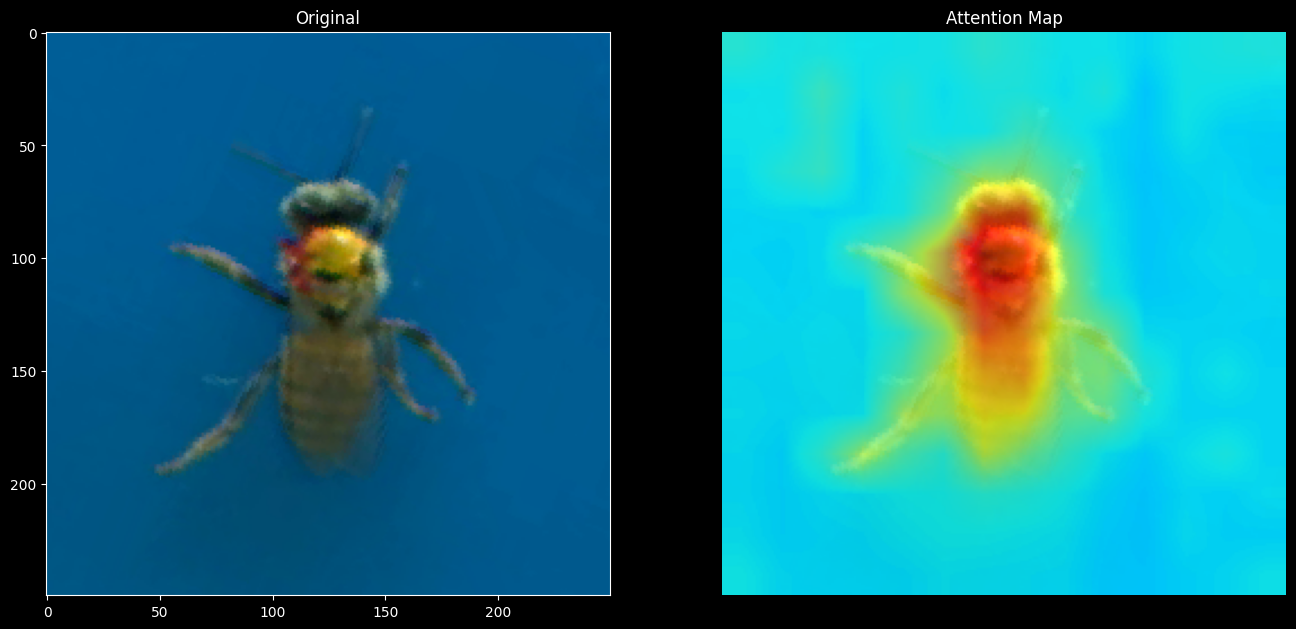

: 

In [47]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(im)
_ = ax2.imshow(result)
plt.axis("off")
probs = torch.nn.Softmax(dim=-1)(logits)
top5 = torch.argsort(probs, dim=-1, descending=True)

# for idx in top5[0, :5]:
#     print(f'{probs[0, idx.item()]:.5f} : {imagenet_labels[idx.item()]}', end='')

### Reference
* [attention_flow](https://github.com/samiraabnar/attention_flow)
* [vit-keras](https://github.com/faustomorales/vit-keras)

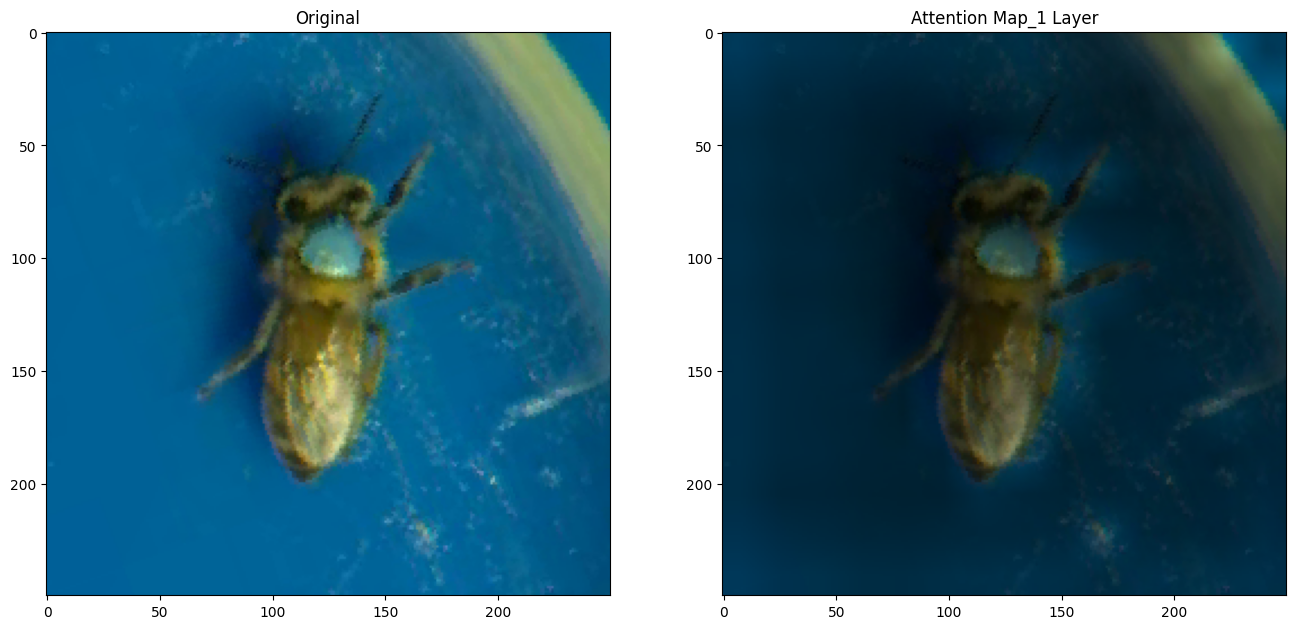

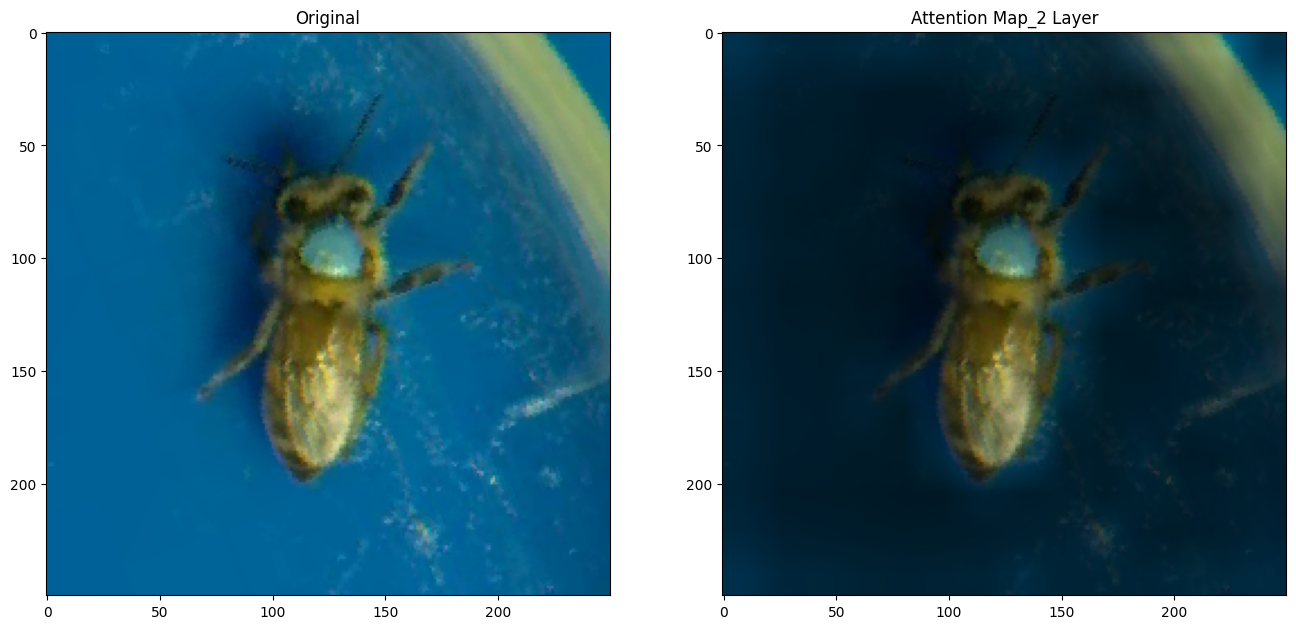

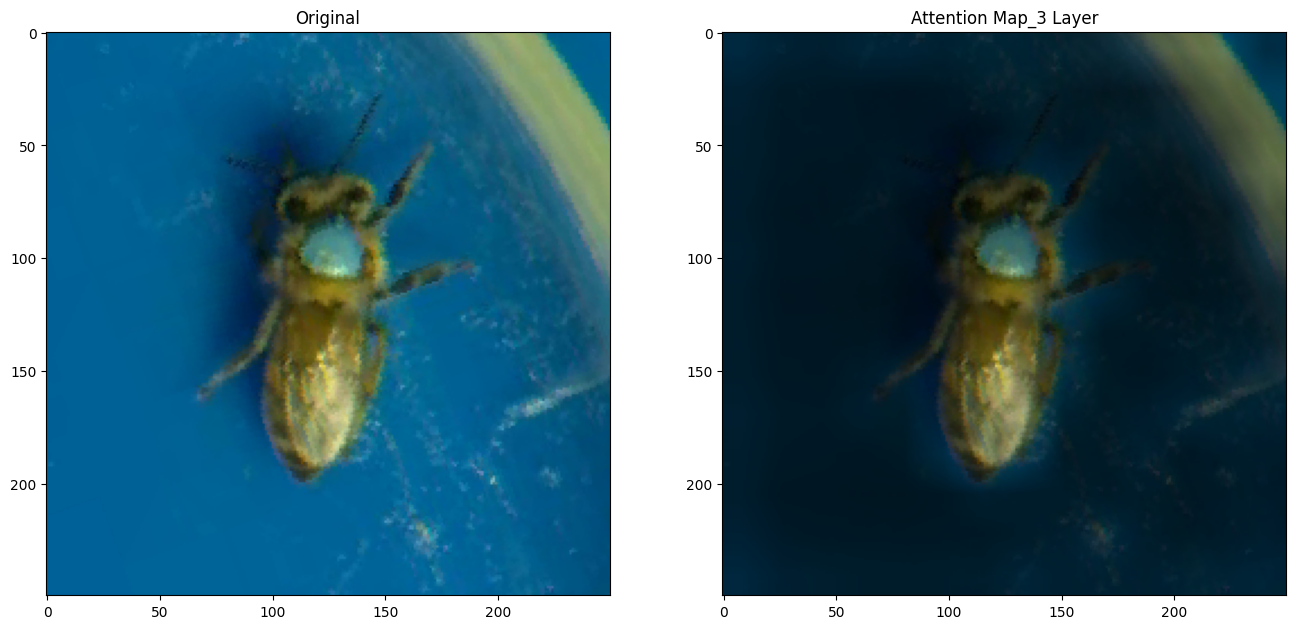

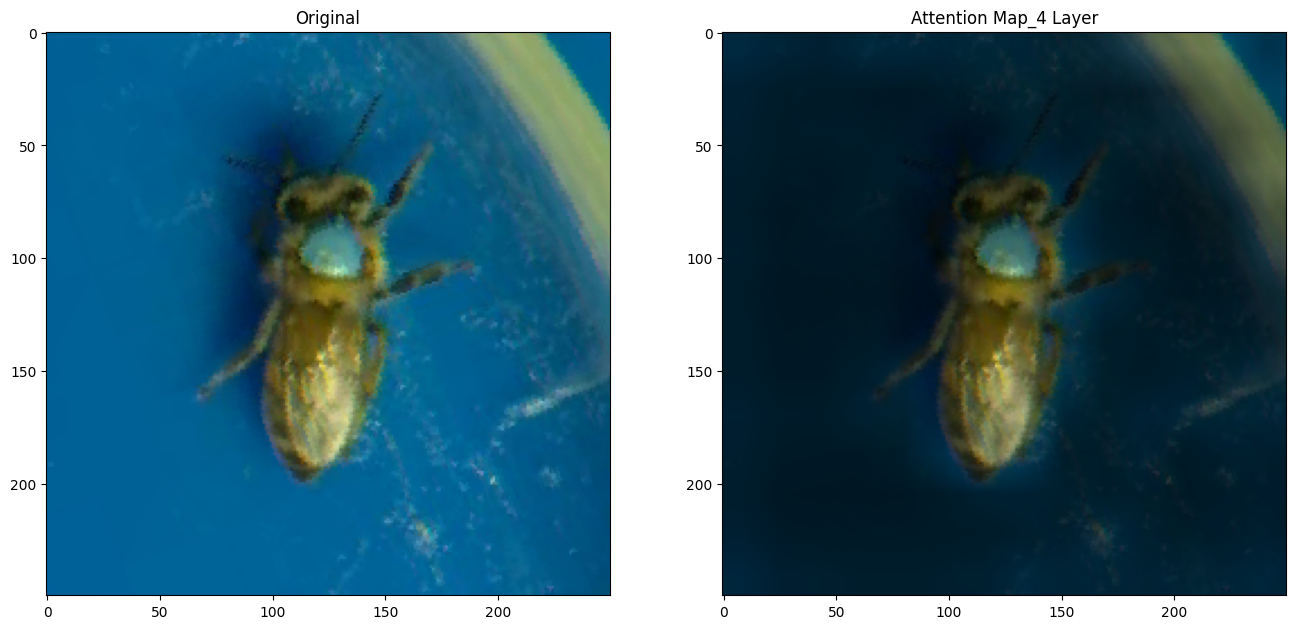

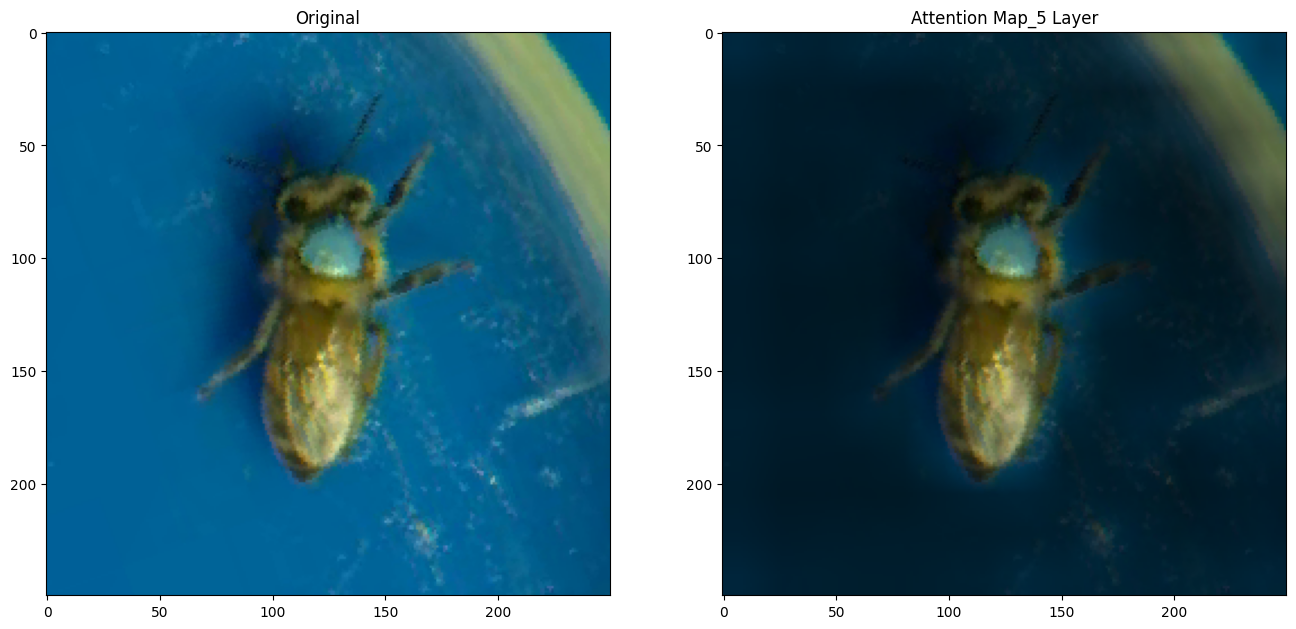

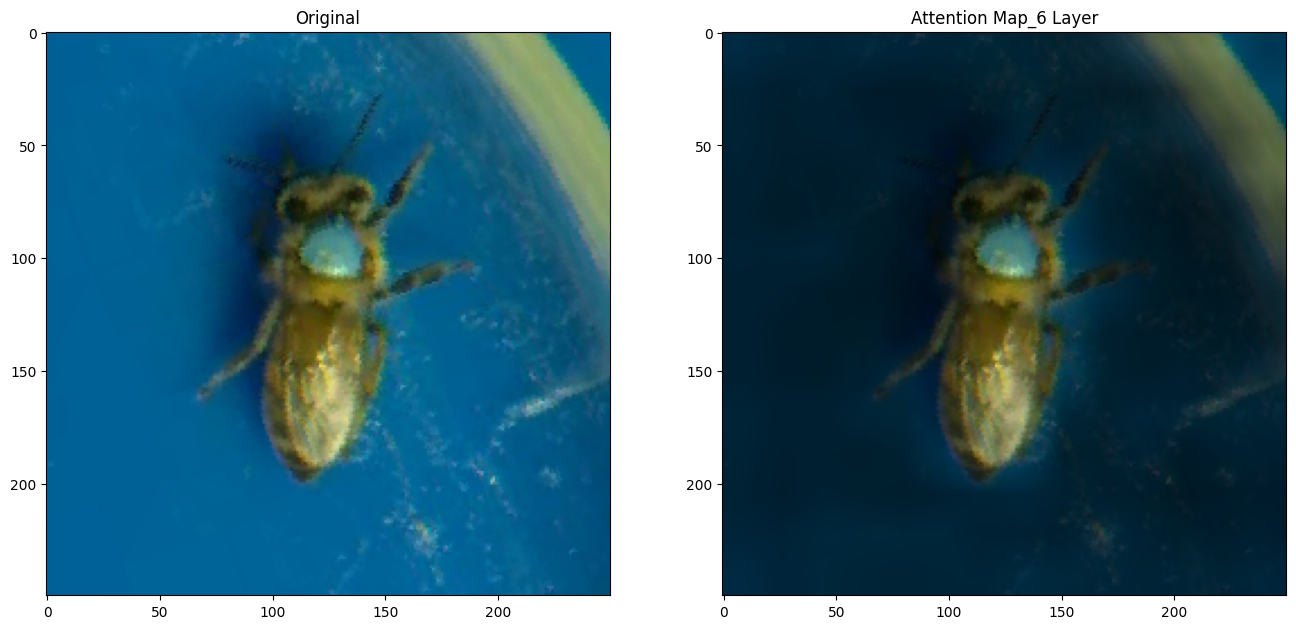

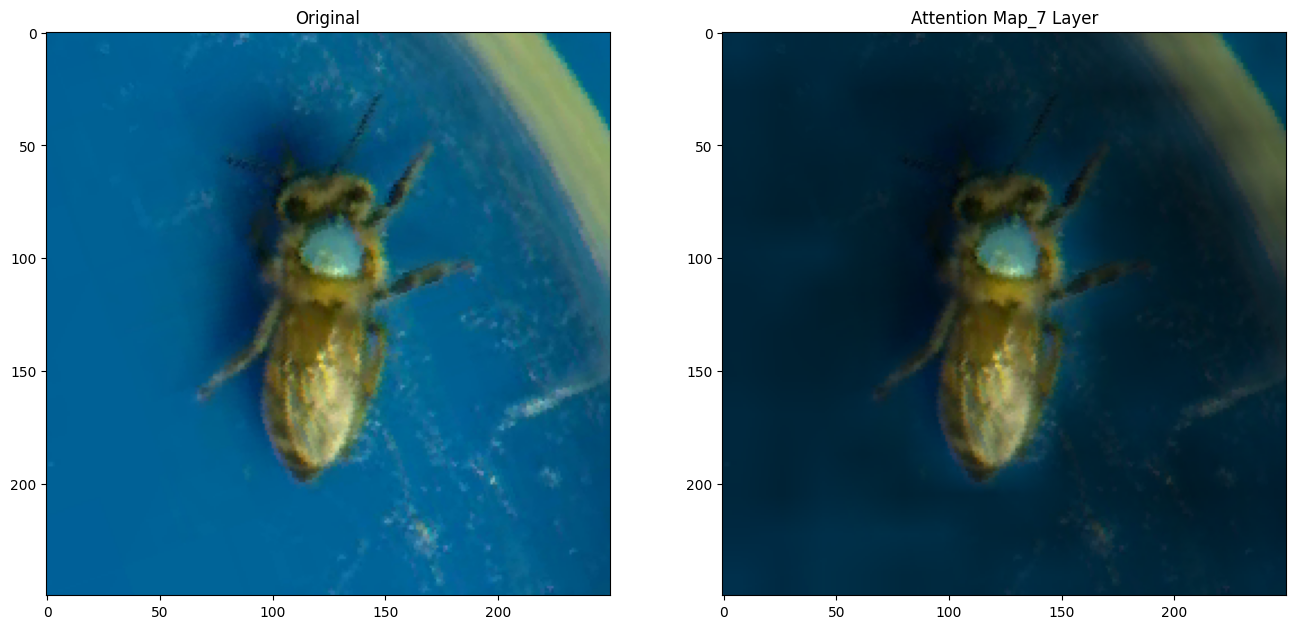

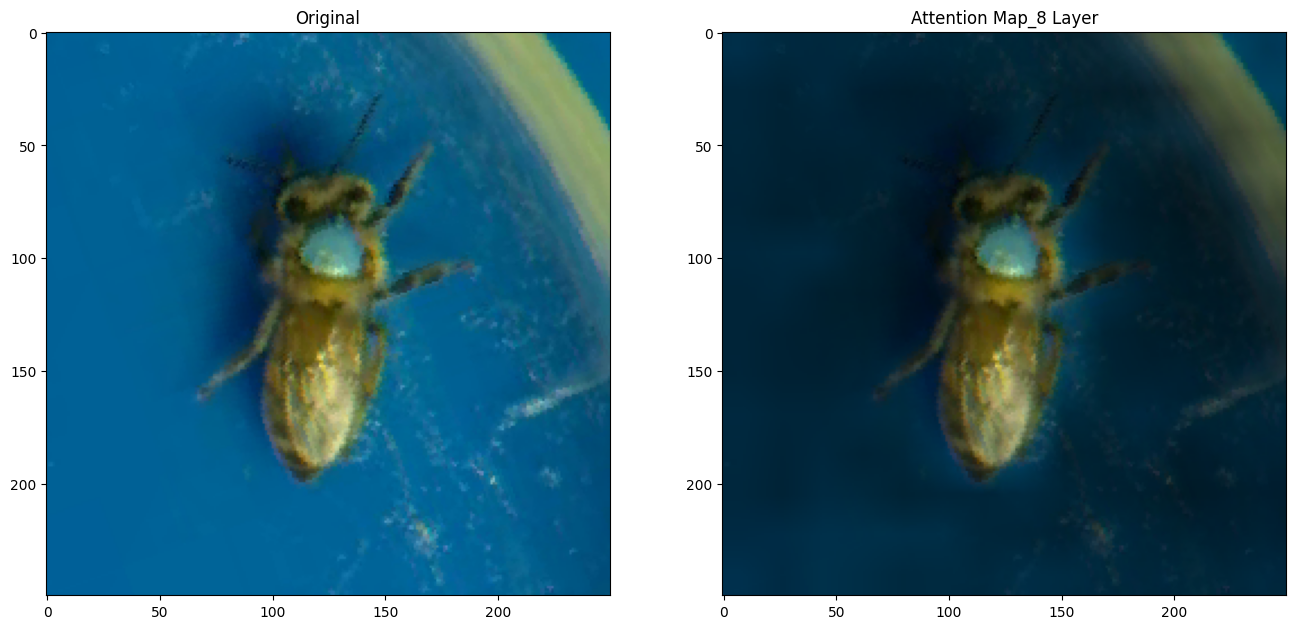

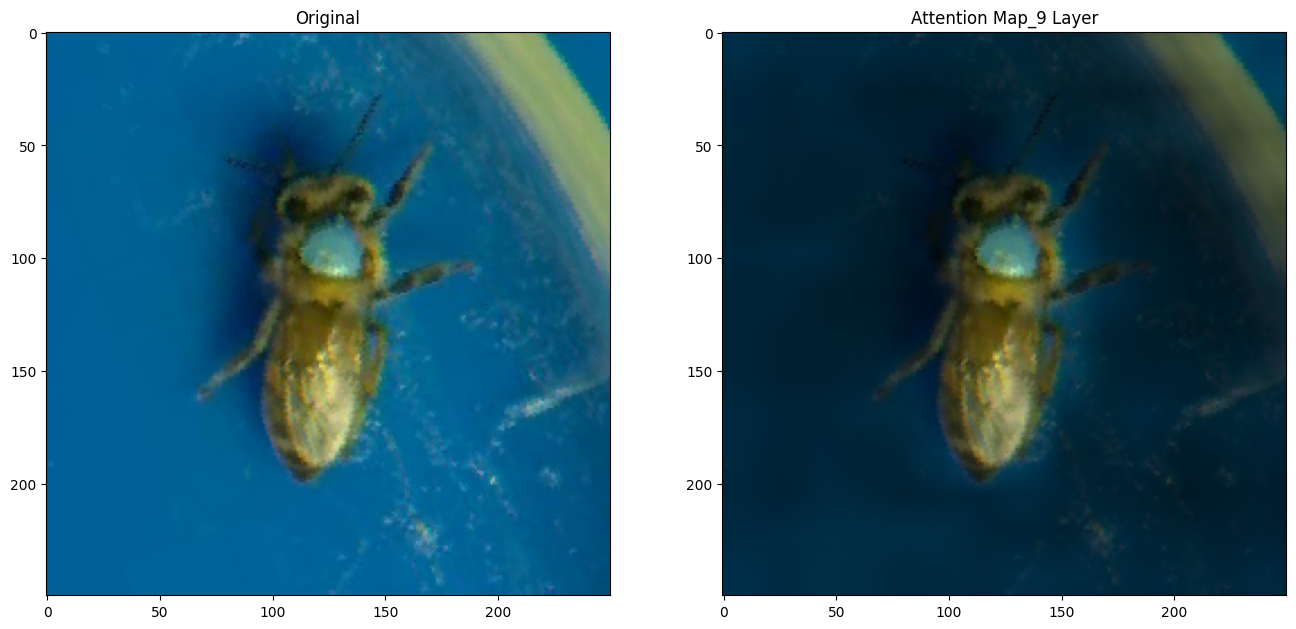

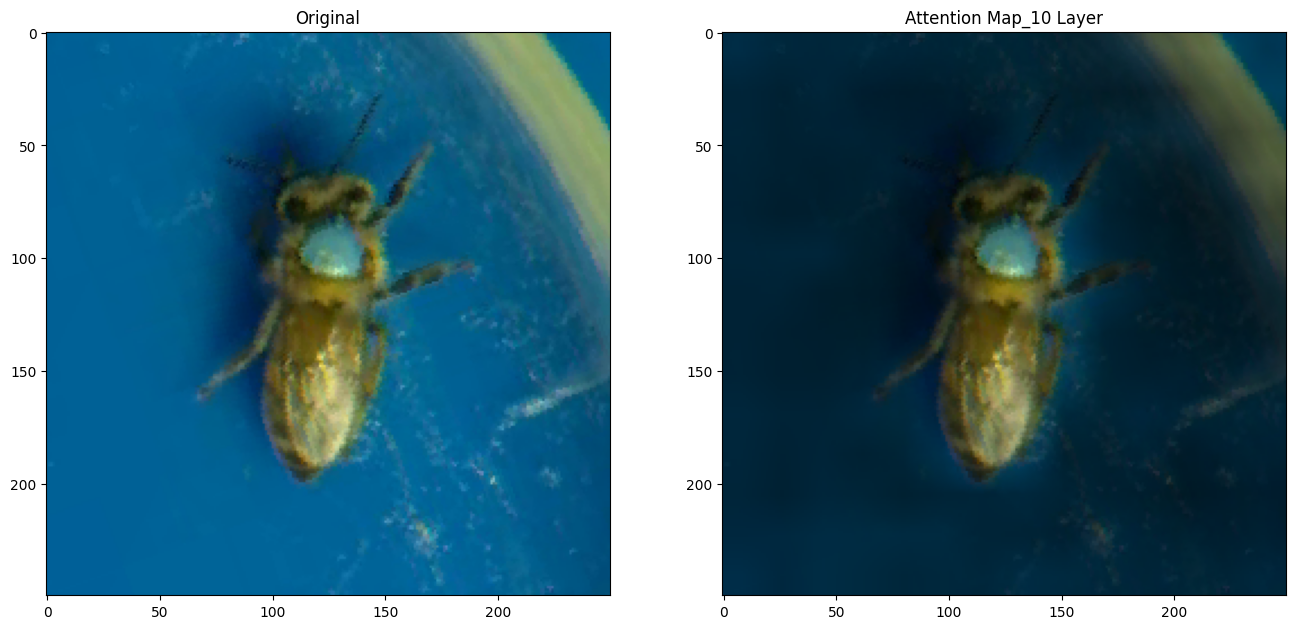

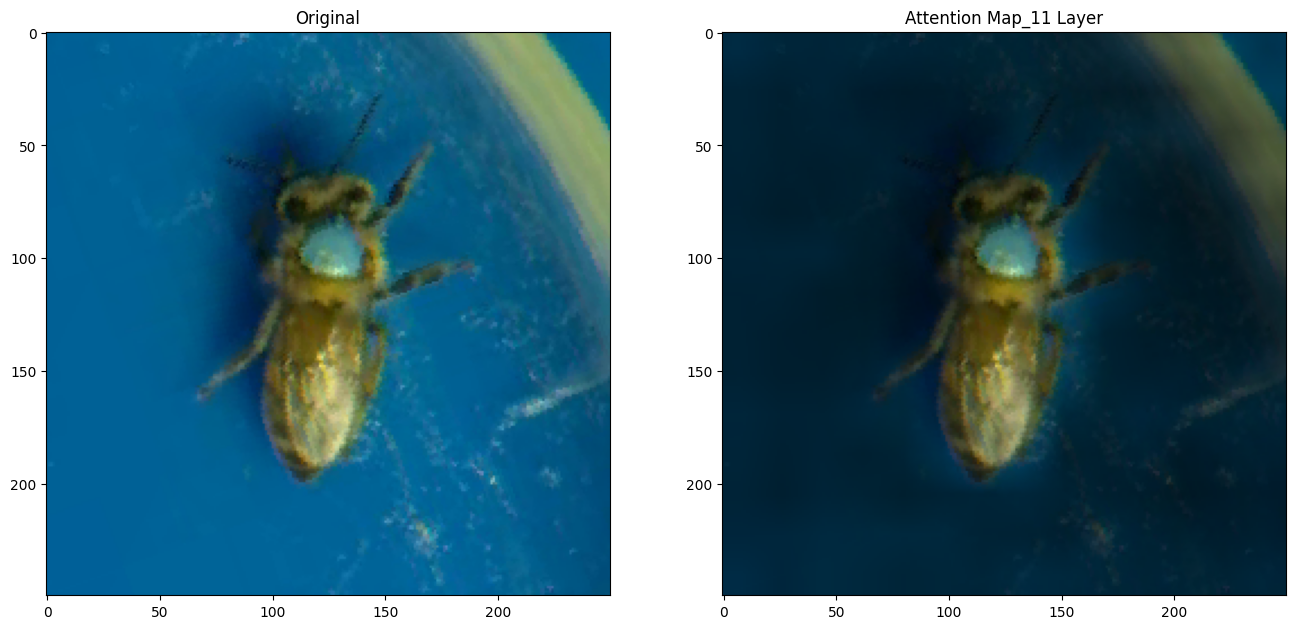

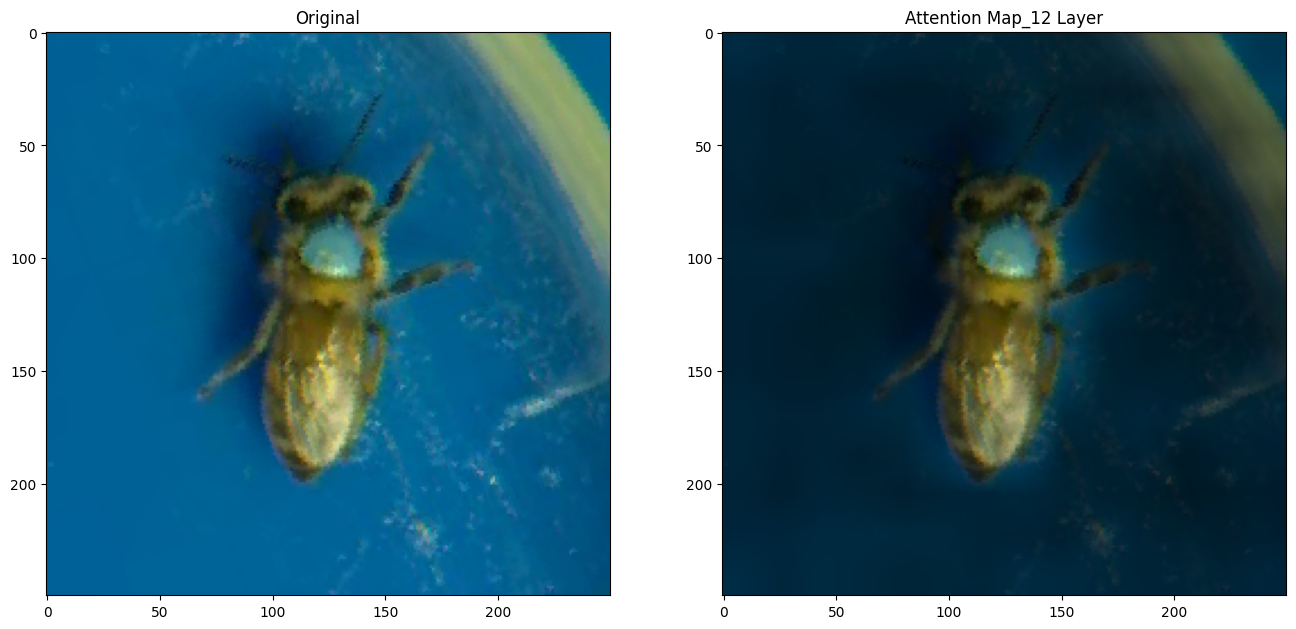

In [56]:
for i, v in enumerate(joint_attentions):
    # Attention from the output token to the input space.
    mask = v[0, 1:].reshape(grid_size, grid_size).cpu().detach().numpy()
    mask = cv2.resize(mask / mask.max(), im.size)[..., np.newaxis]
    result = (mask * im).astype("uint8")

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))
    ax1.set_title('Original')
    ax2.set_title('Attention Map_%d Layer' % (i+1))
    _ = ax1.imshow(im)
    _ = ax2.imshow(result)